In [1]:
from tqdm import tqdm
from datetime import datetime
import pickle
from collections import defaultdict

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.4%}'.format

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from scipy import optimize
from sklearn.model_selection import TimeSeriesSplit, KFold

In [2]:
import pypfopt
from pypfopt import risk_models, expected_returns, objective_functions, plotting

import riskfolio as rp

In [3]:
pd.options.display.float_format = '{:.3}'.format

## Исследование

In [4]:
companies_close_prices = pd.read_csv('data/sp_close_prices.csv', index_col='Date')
prices_changes = companies_close_prices.pct_change(1).dropna()

In [5]:
train_test_ration = 0.5
split_index = int(len(prices_changes) * train_test_ration)
prices_changes_train = prices_changes.iloc[:split_index]
prices_changes_test = prices_changes.iloc[split_index:]
prices_changes_train.iloc[-1].name, len(prices_changes_train), len(prices_changes_test)

('2020-01-31', 523, 524)

In [6]:
sp500_close_prices = pd.read_csv('data/sp500.csv', index_col='Date')
sp500_close_changes = sp500_close_prices.pct_change(1).dropna()

In [7]:
sp500_description = pd.read_csv('data/SP500_companies.csv', index_col=0)
mask = sp500_description['Symbol'].apply(lambda x: x in companies_close_prices.columns)
sp500_description = sp500_description[mask]
sp500_description.head()

Symbol     Security SEC filings  GICS Sector         GICS Sub-Industry  \
0    MMM           3M     reports  Industrials  Industrial Conglomerates   
1    AOS  A. O. Smith     reports  Industrials         Building Products   
2    ABT       Abbott     reports  Health Care     Health Care Equipment   
3   ABBV       AbbVie     reports  Health Care           Pharmaceuticals   
4   ABMD      Abiomed     reports  Health Care     Health Care Equipment   

     Headquarters Location Date first added      CIK      Founded  
0    Saint Paul, Minnesota       1976-08-09    66740         1902  
1     Milwaukee, Wisconsin       2017-07-26    91142         1916  
2  North Chicago, Illinois       1964-03-31     1800         1888  
3  North Chicago, Illinois       2012-12-31  1551152  2013 (1888)  
4   Danvers, Massachusetts       2018-05-31   815094         1981

<AxesSubplot:xlabel='GICS Sector'>

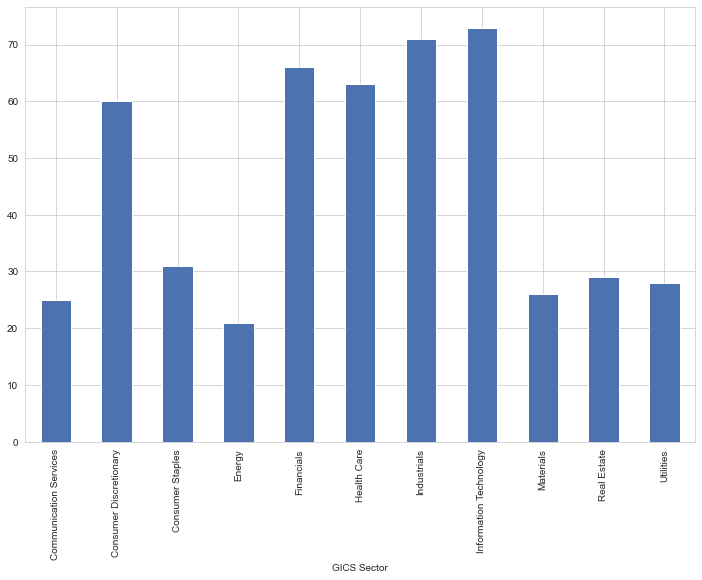

In [8]:
sectors = sp500_description.groupby(by='GICS Sector')['Symbol']
sectors_tickers = sectors.apply(list)
sectors.count().plot.bar(figsize=(12,8))

In [9]:
fig = px.line(data_frame=np.cumsum(sp500_close_changes), template="plotly_white", title="S&P500 Index percentage change")
fig.add_vline(x=prices_changes_train.iloc[-1].name)

## Сравнение методов оценки Expected Returns и Ковариации

In [10]:
methods_mu = ['hist', 'ewma1', 'ewma2']
methods_cov = ['hist', 'ledoit', 'shrunk', 'oas', 'spectral', 'shrink', 'jlogo']

In [11]:
info_dict = dict()
for m_mu in tqdm(methods_mu):
    mu_train = rp.pe.mean_vector(prices_changes_train, method=m_mu)
    mu_test = rp.pe.mean_vector(prices_changes_test, method=m_mu)
    info_dict[m_mu] = np.sum(np.abs(mu_train - mu_test), 1)[0]
pd.Series(info_dict, name='Error').to_frame().T

100%|██████████| 3/3 [00:00<00:00, 59.98it/s]


hist  ewma1  ewma2
Error 0.376   1.78   1.78

In [12]:
info_dict = dict()
for m_cov in tqdm(methods_cov):
    cov_train = np.diag(rp.pe.covar_matrix(prices_changes_train, method=m_cov))
    cov_test = np.diag(rp.pe.covar_matrix(prices_changes_test, method=m_cov))
    info_dict[m_cov] = np.sum(np.abs(cov_train - cov_test), 0)
pd.Series(info_dict, name='Error').to_frame().T

100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


hist  ledoit  shrunk   oas  spectral  shrink  jlogo
Error 0.239   0.238   0.237 0.238     0.239   0.239  0.239

## RiskFolio

### Markovitz Theory

In [13]:
method_mu, method_cov = 'hist', 'shrunk'
portfolio = rp.Portfolio(returns=prices_changes_train, nea=None)
portfolio.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.84)
portfolio.solvers = ['ECOS']
# portfolio.alpha = 0.05

test_mu = rp.pe.mean_vector(prices_changes_test, method=method_mu)
test_cov = rp.pe.covar_matrix(prices_changes_test, method=method_cov)

valuable_gamma = 0.5
valuable_threshold = (1 / len(sp500_description)) * valuable_gamma

In [19]:
def asses_portfolio(w, train_mu, train_cov, rm):
    if w is not None:
        result_dict = dict()
        result_dict['Risk on Train'] = rp.Sharpe_Risk(w, train_cov, prices_changes_train, rm=rm)
        result_dict['Risk on Test'] = rp.Sharpe_Risk(w, test_cov, prices_changes_test, rm=rm)
        result_dict['Mean Risk'] = (result_dict['Risk on Train'] + result_dict['Risk on Test']) / 2
        result_dict['Risk Change'] = "%.2f" % ((result_dict['Risk on Test'] - result_dict['Risk on Train']) / result_dict['Risk on Train'] * 100) +"%"
        result_dict['Sharpe on Train'] = rp.Sharpe(w, train_mu, train_cov, prices_changes_train, rm=rm)
        result_dict['Sharpe on Test'] = rp.Sharpe(w, test_mu, test_cov, prices_changes_test, rm=rm)
        result_dict['Mean Sharpe'] = (result_dict['Sharpe on Train'] + result_dict['Sharpe on Test']) / 2
        result_dict['Sharpe Change'] = "%.2f" % ((result_dict['Sharpe on Test'] - result_dict['Sharpe on Train']) / result_dict['Sharpe on Train'] * 100) + "%"
        result_dict['E.Return on Train'] =  (train_mu @ w).iloc[0][0]
        result_dict['E.Return on Test'] = (test_mu @ w).iloc[0][0]
        result_dict['Mean E.Return'] = (result_dict['E.Return on Train'] + result_dict['E.Return on Test']) / 2
        result_dict['E.Return Change'] = "%.2f" % ((result_dict['E.Return on Test'] - result_dict['E.Return on Train']) / result_dict['E.Return on Train'] * 100) + "%"
        result_dict['R.Return on Train'] = np.cumsum(prices_changes_train @ w).iloc[-1][0]
        result_dict['R.Return on Test'] = np.cumsum(prices_changes_test @ w).iloc[-1][0]
        result_dict['Mean R.Return'] = (result_dict['R.Return on Train'] + result_dict['R.Return on Test']) / 2
        result_dict['R.Return Change'] = "%.2f" % ((result_dict['R.Return on Test'] - result_dict['R.Return on Train']) / result_dict['R.Return on Train'] * 100) + "%"
        result_dict['Valuable Allocations'] = np.count_nonzero(w >= valuable_threshold)
    else:
        result_dict = dict()
    del result_dict['Risk on Test'], result_dict['Risk on Train'],\
            result_dict['R.Return on Train'], result_dict['R.Return on Test'],\
            result_dict['E.Return on Train'], result_dict['E.Return on Test'],\
            result_dict['Sharpe on Train'], result_dict['Sharpe on Test']
    return result_dict

In [20]:
def optimize_objective(objective='Sharpe'):
    rms = [ 'MV', 'MSV', 'MAD', 'FLPM', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI' ]
    optimal_rm = dict()
    pbar = tqdm(rms)
    for i in pbar:
        pbar.set_description("Processing %s" % i)
        w = portfolio.optimization(model='Classic', rm=i, obj=objective, rf=0, l=1, hist=True)
        optimal_rm[i] = asses_portfolio(w, portfolio.mu, portfolio.cov, rm=i)
    return optimal_rm

In [21]:
def rp_objective():
    rms = [ 'MV', 'MSV', 'MAD' ]
    optimal_rm = dict()
    pbar = tqdm(rms)
    for i in pbar:
        pbar.set_description("Processing %s" % i)
        w = portfolio.rp_optimization(model='Classic', rm=i, rf=0, b=None, hist=True)
        optimal_rm[i] = asses_portfolio(w, portfolio.mu, portfolio.cov, rm=i)
    return optimal_rm

#### Средний портфель (бейзлайн)
Составлен из равномерно рапредленных весов

In [22]:
w = pd.DataFrame(np.ones(portfolio.numassets) * (1 / portfolio.numassets), prices_changes.columns)
optimal_rm = {}
for i in [ 'MV', 'MSV', 'MAD', 'FLPM', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI' ]:
    optimal_rm[i] = asses_portfolio(w, portfolio.mu, portfolio.cov, rm=i)
pd.DataFrame(optimal_rm)

MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0129   0.0101  0.00876  0.00409   0.0816    0.337   
Risk Change           101.57%   96.46%   73.85%   72.05%  250.03%  118.37%   
Mean Sharpe            0.0493   0.0626   0.0711    0.152  0.00915  0.00191   
Sharpe Change           0.08%    2.67%   16.03%   17.25%  -42.37%   -7.63%   
Mean E.Return        0.000635 0.000635 0.000635 0.000635 0.000635 0.000635   
E.Return Change       101.72%  101.72%  101.72%  101.72%  101.72%  101.72%   
Mean R.Return           0.333    0.333    0.333    0.333    0.333    0.333   
R.Return Change       102.10%  102.10%  102.10%  102.10%  102.10%  102.10%   
Valuable Allocations      493      493      493      493      493      493   

                          ADD     CDaR      UCI  
Mean Risk              0.0366    0.216   0.0654  
Risk Change            40.40%  121.65%   81.20%  
Mean Sharpe            0.0169    0.003  0.00956  
Sharpe Change          43.67%   -8.99%   11.32%  
Mean E.Return        0.000635 0.000635 0.000635  
E.Return Change       101.72%  101.72%  101.72%  
Mean R.Return           0.333    0.333    0.333  
R.Return Change       102.10%  102.10%  102.10%  
Valuable Allocations      493      493      493

In [23]:
w.mean()[0], w.std()[0]

(0.0020283975659229053, 1.5628369603048497e-17)

<AxesSubplot:title={'center':'Risk (Semi Standard Deviation) Contribution per Asset'}>

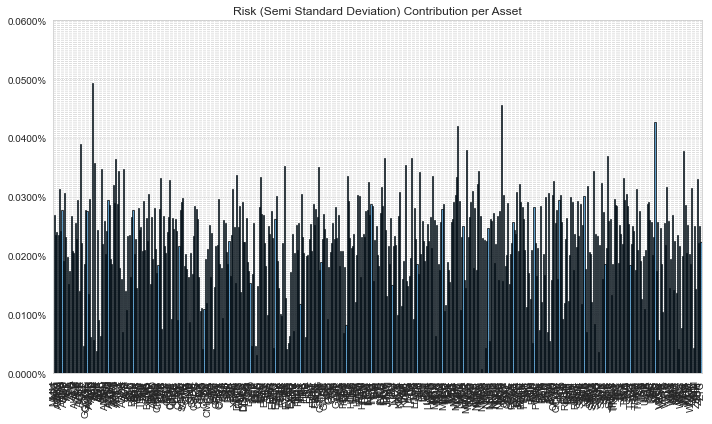

In [24]:
rp.plot_risk_con(w, cov=portfolio.cov, returns=portfolio.returns, rm='MSV')

#### Using minimum number of tickers
Without restrictions

In [25]:
pd.DataFrame(optimize_objective('Sharpe'))

Processing UCI: 100%|██████████| 9/9 [00:37<00:00,  4.14s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0134   0.0105  0.00894  0.00382   0.0654    0.193   
Risk Change           112.51%  116.78%   86.04%  124.26%  410.19%  391.77%   
Mean Sharpe              0.14    0.199    0.188    0.483   0.0527   0.0151   
Sharpe Change         -74.39%  -71.55%  -71.24%  -76.10%  -86.92%  -85.05%   
Mean E.Return         0.00148  0.00165   0.0014  0.00141  0.00167  0.00149   
E.Return Change       -45.59%  -38.33%  -46.50%  -46.39%  -33.26%  -26.47%   
Mean R.Return           0.775    0.865    0.735    0.739    0.872    0.778   
R.Return Change       -45.48%  -38.21%  -46.39%  -46.29%  -33.13%  -26.32%   
Valuable Allocations       24       16       22       22       10        9   

                          ADD     CDaR      UCI  
Mean Risk              0.0214    0.134   0.0382  
Risk Change           423.94%  446.28%  365.43%  
Mean Sharpe             0.134   0.0221   0.0689  
Sharpe Change         -87.15%  -88.69%  -86.46%  
Mean E.Return         0.00136  0.00133  0.00134  
E.Return Change       -32.65%  -38.24%  -36.96%  
Mean R.Return           0.713    0.698    0.699  
R.Return Change       -32.52%  -38.12%  -36.84%  
Valuable Allocations       25       16       21

In [26]:
pd.DataFrame(optimize_objective('MaxRet'))

Processing UCI: 100%|██████████| 9/9 [00:16<00:00,  1.81s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0501   0.0344   0.0361   0.0155    0.258    0.709   
Risk Change            13.58%   15.85%   10.32%   16.15%    1.87%   30.72%   
Mean Sharpe             0.108    0.158    0.149    0.351   0.0208  0.00779   
Sharpe Change         -30.03%  -31.40%  -27.96%  -31.58%  -21.99%  -39.21%   
Mean E.Return         0.00534  0.00534  0.00534  0.00534  0.00534  0.00534   
E.Return Change       -20.53%  -20.53%  -20.53%  -20.53%  -20.53%  -20.53%   
Mean R.Return             2.8      2.8      2.8      2.8      2.8      2.8   
R.Return Change       -20.38%  -20.38%  -20.38%  -20.38%  -20.38%  -20.38%   
Valuable Allocations        1        1        1        1        1        1   

                          ADD     CDaR      UCI  
Mean Risk               0.172      0.6    0.245  
Risk Change            10.98%   25.27%   10.40%  
Mean Sharpe            0.0313  0.00913    0.022  
Sharpe Change         -28.39%  -36.56%  -28.02%  
Mean E.Return         0.00534  0.00534  0.00534  
E.Return Change       -20.53%  -20.53%  -20.53%  
Mean R.Return             2.8      2.8      2.8  
R.Return Change       -20.38%  -20.38%  -20.38%  
Valuable Allocations        1        1        1

In [27]:
pd.DataFrame(optimize_objective('MinRisk'))

Processing UCI: 100%|██████████| 9/9 [00:30<00:00,  3.41s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk                0.01  0.00731  0.00679  0.00303   0.0683     0.19   
Risk Change           191.60%  181.90%  157.60%  167.31%  772.19%  709.53%   
Mean Sharpe            0.0546    0.071   0.0757    0.278   0.0267  0.00846   
Sharpe Change         -51.77%  -52.68%  -34.88%  -69.14%  -89.02%  -88.19%   
Mean E.Return        0.000454  0.00043 0.000466 0.000639 0.000662 0.000618   
E.Return Change        40.64%   33.40%   67.75%  -17.51%   -4.19%   -4.41%   
Mean R.Return           0.238    0.225    0.244    0.335    0.347    0.324   
R.Return Change        40.91%   33.65%   68.07%  -17.36%   -4.01%   -4.22%   
Valuable Allocations       57       36       49       48       14       13   

                          ADD     CDaR      UCI  
Mean Risk              0.0187    0.122   0.0363  
Risk Change           458.91%  689.82%  526.77%  
Mean Sharpe            0.0989   0.0155   0.0474  
Sharpe Change         -88.32%  -89.83%  -90.23%  
Mean E.Return        0.000831 0.000697 0.000696  
E.Return Change       -34.72%  -19.71%  -38.77%  
Mean R.Return           0.435    0.365    0.364  
R.Return Change       -34.59%  -19.56%  -38.65%  
Valuable Allocations       37       24       26

In [28]:
pd.DataFrame(optimize_objective('Utility'))

Processing UCI: 100%|██████████| 9/9 [00:29<00:00,  3.33s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0394  0.00764  0.00746  0.00343    0.066    0.189   
Risk Change            20.84%  176.63%  114.77%  132.92%  729.83%  706.77%   
Mean Sharpe              0.12    0.132    0.175    0.479   0.0341  0.00857   
Sharpe Change         -36.94%  -73.94%  -70.75%  -74.69%  -88.81%  -88.20%   
Mean E.Return         0.00461 0.000729  0.00104  0.00125  0.00084 0.000625   
E.Return Change       -23.80%  -27.90%  -37.18%  -41.06%   -7.13%   -4.76%   
Mean R.Return            2.41    0.381    0.546    0.655     0.44    0.327   
R.Return Change       -23.66%  -27.76%  -37.06%  -40.95%   -6.96%   -4.58%   
Valuable Allocations        3       33       37       26       15       14   

                          ADD     CDaR      UCI  
Mean Risk              0.0176    0.122    0.036  
Risk Change           408.75%  693.62%  518.64%  
Mean Sharpe             0.117   0.0156   0.0503  
Sharpe Change         -87.37%  -89.94%  -90.15%  
Mean E.Return        0.000983 0.000697 0.000738  
E.Return Change       -35.72%  -20.19%  -39.05%  
Mean R.Return           0.514    0.365    0.387  
R.Return Change       -35.60%  -20.04%  -38.93%  
Valuable Allocations       30       22       25

#### All tickers
Using inverse Herfindahl-Hirschman Index (HHI)

In [29]:
index_like_portfolios = []

In [30]:
pd.DataFrame(rp_objective())

Processing MAD: 100%|██████████| 3/3 [00:13<00:00,  4.40s/it]


MV      MSV      MAD
Mean Risk              0.0118  0.00923  0.00791
Risk Change           121.30%  116.16%   87.28%
Mean Sharpe            0.0517   0.0664   0.0746
Sharpe Change         -23.91%  -22.45%  -10.71%
Mean E.Return        0.000581 0.000585  0.00058
E.Return Change        68.38%   67.63%   67.23%
Mean R.Return           0.304    0.306    0.304
R.Return Change        68.70%   67.95%   67.55%
Valuable Allocations      489      489      485

In [31]:
w = portfolio.rp_optimization(model='Classic', rm='MSV', rf=0, b=None, hist=True)
index_like_portfolios.append(np.cumsum(prices_changes @ w).rename({'weights': 'Risk Parity'}, axis=1))

In [32]:
w.mean()[0], w.std()[0]

(0.0020283975659229226, 0.001160589709109881)

##### Ограничения

In [33]:
portfolio.nea = len(sp500_description) * (1 - valuable_gamma)
portfolio.ainequality = np.eye(len(sp500_description))
portfolio.binequality = np.array([valuable_threshold] * len(sp500_description))[:, np.newaxis]

In [34]:
pd.DataFrame(optimize_objective('Sharpe'))

Processing UCI: 100%|██████████| 9/9 [00:38<00:00,  4.30s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0122  0.00959  0.00821  0.00369   0.0774    0.288   
Risk Change           105.53%  102.60%   72.43%   84.41%  332.19%  186.63%   
Mean Sharpe            0.0872    0.111    0.122    0.278   0.0198  0.00424   
Sharpe Change         -51.97%  -51.10%  -42.96%  -46.35%  -76.45%  -65.00%   
Mean E.Return        0.000936 0.000938  0.00093 0.000933 0.000943 0.000938   
E.Return Change        -1.29%   -0.92%   -1.65%   -1.07%    1.76%    0.33%   
Mean R.Return            0.49    0.491    0.487    0.488    0.493    0.491   
R.Return Change        -1.10%   -0.73%   -1.46%   -0.88%    1.95%    0.52%   
Valuable Allocations      493      493      493      493      493      493   

                          ADD     CDaR      UCI  
Mean Risk              0.0253    0.172    0.049  
Risk Change           182.72%  217.82%  198.57%  
Mean Sharpe            0.0466  0.00737   0.0248  
Sharpe Change         -64.66%  -68.36%  -66.51%  
Mean E.Return        0.000908 0.000926 0.000916  
E.Return Change        -0.09%    0.56%   -0.01%  
Mean R.Return           0.475    0.485     0.48  
R.Return Change         0.10%    0.75%    0.18%  
Valuable Allocations      493      493      493

In [35]:
w = portfolio.optimization(model='Classic', rm='UCI', obj='Sharpe', rf=0, l=1, hist=True)
index_like_portfolios.append(np.cumsum(prices_changes @ w).rename({'weights': 'Sharpe'}, axis=1))

In [36]:
w.mean()[0], w.std()[0]

(0.002028397565922922, 0.0020304597646902396)

In [37]:
pd.DataFrame(optimize_objective('MaxRet'))

Processing UCI: 100%|██████████| 9/9 [00:29<00:00,  3.23s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0132   0.0104  0.00912  0.00409   0.0817    0.312   
Risk Change            84.59%   81.70%   58.91%   66.91%  255.73%  127.55%   
Mean Sharpe            0.0855    0.108    0.119    0.269   0.0183  0.00389   
Sharpe Change         -43.68%  -42.79%  -34.58%  -37.72%  -70.78%  -54.32%   
Mean E.Return         0.00104  0.00104  0.00104  0.00104  0.00104  0.00104   
E.Return Change         3.95%    3.95%    3.95%    3.95%    3.95%    3.95%   
Mean R.Return           0.543    0.543    0.543    0.543    0.543    0.543   
R.Return Change         4.15%    4.15%    4.15%    4.15%    4.15%    4.15%   
Valuable Allocations      493      493      493      493      493      493   

                          ADD     CDaR      UCI  
Mean Risk              0.0292    0.193   0.0558  
Risk Change           106.20%  139.96%  121.11%  
Mean Sharpe            0.0401  0.00643   0.0215  
Sharpe Change         -49.59%  -56.68%  -52.99%  
Mean E.Return         0.00104  0.00104  0.00104  
E.Return Change         3.95%    3.95%    3.95%  
Mean R.Return           0.543    0.543    0.543  
R.Return Change         4.15%    4.15%    4.15%  
Valuable Allocations      493      493      493

In [38]:
w = portfolio.optimization(model='Classic', rm='UCI', obj='MaxRet', rf=0, l=1, hist=True)
index_like_portfolios.append(np.cumsum(prices_changes @ w).rename({'weights': 'Max Return'}, axis=1))

In [39]:
w.mean()[0], w.std()[0]

(0.0020283975659229213, 0.002030457899374348)

In [40]:
pd.DataFrame(optimize_objective('MinRisk'))

Processing UCI:  89%|████████▉ | 8/9 [00:32<00:03,  3.51s/it] /home/hivaze/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

Processing UCI: 100%|██████████| 9/9 [00:42<00:00,  4.77s/it]


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0111  0.00869  0.00731  0.00338   0.0744     0.27   
Risk Change           138.72%  133.37%   99.21%  104.70%  377.89%  236.42%   
Mean Sharpe            0.0545   0.0705   0.0779    0.203   0.0147  0.00283   
Sharpe Change         -41.99%  -41.13%  -28.09%  -43.12%  -70.62%  -59.89%   
Mean E.Return        0.000539  0.00055 0.000538 0.000621 0.000701 0.000589   
E.Return Change        38.48%   37.39%   43.25%   16.43%   40.38%   34.94%   
Mean R.Return           0.282    0.288    0.282    0.325    0.367    0.308   
R.Return Change        38.74%   37.66%   43.52%   16.66%   40.65%   35.19%   
Valuable Allocations      493      493      493      493      493      493   

                          ADD     CDaR      UCI  
Mean Risk              0.0246    0.162   0.0459  
Risk Change           209.91%  256.42%  261.07%  
Mean Sharpe            0.0393  0.00563   0.0226  
Sharpe Change         -65.28%  -66.54%  -71.44%  
Mean E.Return        0.000729 0.000658 0.000709  
E.Return Change         7.61%   19.24%    3.12%  
Mean R.Return           0.381    0.344    0.371  
R.Return Change         7.82%   19.47%    3.32%  
Valuable Allocations      493      493      493

In [41]:
w = portfolio.optimization(model='Classic', rm='ADD', obj='MinRisk', rf=0, l=1, hist=True)
index_like_portfolios.append(np.cumsum(prices_changes @ w).rename({'weights': 'Min Risk'}, axis=1))

In [42]:
w.mean()[0], w.std()[0]

(0.0020283975659229196, 0.0020304579127025744)

In [43]:
pd.DataFrame(optimize_objective('Utility'))

Processing UCI: 100%|██████████| 9/9 [00:34<00:00,  3.85s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0131  0.00872  0.00741  0.00345   0.0743     0.27   
Risk Change            87.43%  130.38%   90.45%   98.90%  376.95%  236.44%   
Mean Sharpe            0.0863   0.0847    0.105     0.25   0.0153  0.00284   
Sharpe Change         -45.36%  -50.52%  -45.13%  -49.29%  -71.84%  -60.08%   
Mean E.Return         0.00103  0.00064 0.000709 0.000771  0.00072  0.00059   
E.Return Change         2.41%   13.99%    4.50%    0.85%   34.30%   34.31%   
Mean R.Return           0.537    0.335    0.371    0.403    0.377    0.309   
R.Return Change         2.61%   14.21%    4.70%    1.04%   34.55%   34.57%   
Valuable Allocations      493      493      493      493      493      493   

                          ADD     CDaR      UCI  
Mean Risk              0.0246    0.162   0.0473  
Risk Change           208.64%  256.51%  232.77%  
Mean Sharpe            0.0405  0.00568   0.0204  
Sharpe Change         -65.63%  -66.73%  -66.61%  
Mean E.Return        0.000747 0.000662 0.000707  
E.Return Change         6.07%   18.60%   11.10%  
Mean R.Return           0.391    0.347     0.37  
R.Return Change         6.27%   18.83%   11.31%  
Valuable Allocations      493      493      493

In [44]:
w = portfolio.optimization(model='Classic', rm='FLPM', obj='Utility', rf=0, l=1, hist=True)
index_like_portfolios.append(np.cumsum(prices_changes @ w).rename({'weights': 'Utility'}, axis=1))

In [45]:
w.mean()[0], w.std()[0]

(0.0020283975659229213, 0.0020304578613219433)

#### Демонстрация

In [46]:
index_like_portfolios = pd.concat(index_like_portfolios, axis=1)
index_like_portfolios['S&P500 Original'] = np.cumsum(sp500_close_changes)
index_like_portfolios['Baseline'] = np.cumsum(prices_changes @ np.ones(portfolio.numassets) * (1 / portfolio.numassets))

In [47]:
fig = px.line(index_like_portfolios, template="plotly_white", title='Оптимизированные индексы на основе S&P500')
fig.add_vline(x=prices_changes_train.iloc[-1].name)

### Hierarchical Risk Parity

In [48]:
hc_portfolio = rp.HCPortfolio(returns=prices_changes_train)

/home/hivaze/miniconda3/lib/python3.8/site-packages/riskfolio/PlotFunctions.py:2256: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Axes:>

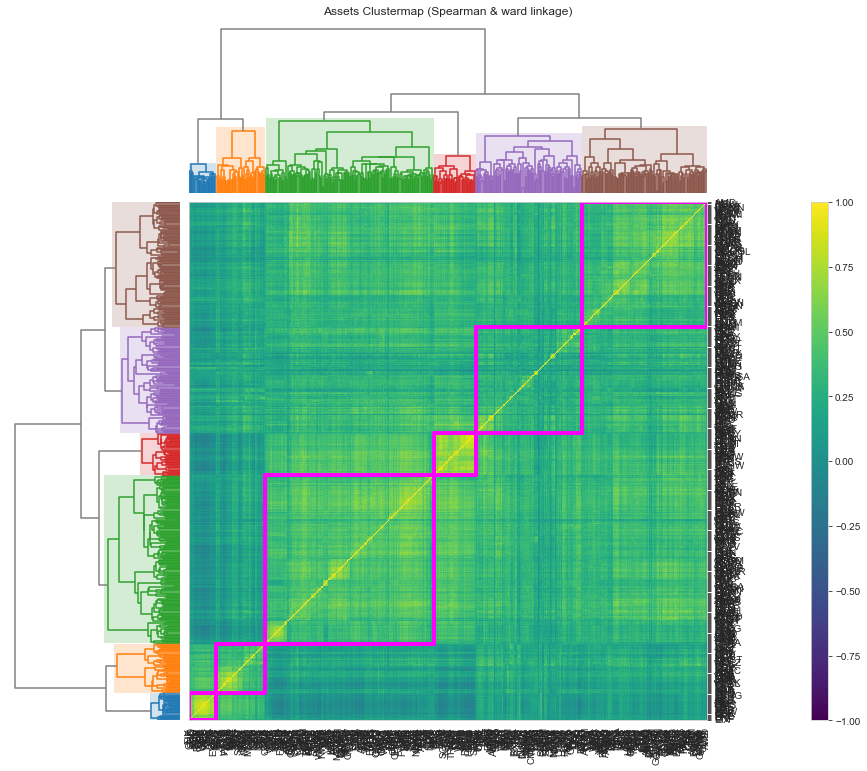

In [49]:
rp.plot_clusters(returns=hc_portfolio.returns,
                      codependence='spearman',
                      linkage='ward',
                      k=None,
                      max_k=10,
                      leaf_order=True,
                      dendrogram=True,
                      #linecolor='tab:purple',
                      ax=None)

In [50]:
def optimize_hierarchical(model='HRP', obj='Sharpe', linkage='ward', max_k=10):
    rms = [ 'MV', 'MSV', 'MAD', 'FLPM', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI' ]
    optimal_rm = dict()
    pbar = tqdm(rms)
    for i in pbar:
        pbar.set_description("Processing %s" % i)
        w = hc_portfolio.optimization(model=model, max_k=max_k, obj=obj,
                                  codependence='spearman', covariance='shrunk',
                                  rm=i, linkage=linkage)
        optimal_rm[i] = asses_portfolio(w, portfolio.mu, portfolio.cov, rm=i)
    return optimal_rm

In [51]:
pd.DataFrame(optimize_hierarchical(model='HRP'))

Processing UCI: 100%|██████████| 9/9 [01:20<00:00,  8.98s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0116  0.00954  0.00812  0.00375   0.0802    0.287   
Risk Change           122.25%  106.99%   81.17%   81.55%  247.53%  185.10%   
Mean Sharpe            0.0507   0.0636   0.0725    0.164   0.0092  0.00271   
Sharpe Change         -27.86%  -13.82%   -1.62%  -10.20%  -44.81%  -55.60%   
Mean E.Return        0.000551 0.000591 0.000587 0.000604  0.00062 0.000634   
E.Return Change        60.32%   78.38%   78.24%   63.04%   91.80%   26.57%   
Mean R.Return           0.288     0.31    0.308    0.316    0.325    0.332   
R.Return Change        60.63%   78.72%   78.58%   63.35%   92.16%   26.82%   
Valuable Allocations      393      481      478      480      467      393   

                          ADD     CDaR      UCI  
Mean Risk              0.0262    0.173   0.0507  
Risk Change           154.10%  202.27%  175.62%  
Mean Sharpe            0.0339  0.00482   0.0171  
Sharpe Change         -59.38%  -60.13%  -60.17%  
Mean E.Return        0.000723 0.000654 0.000692  
E.Return Change         3.22%   20.53%    9.77%  
Mean R.Return           0.379    0.343    0.362  
R.Return Change         3.41%   20.76%    9.98%  
Valuable Allocations      327      359      342

In [52]:
pd.DataFrame(optimize_hierarchical(model='NCO', obj='Sharpe'))

Processing UCI: 100%|██████████| 9/9 [00:20<00:00,  2.29s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0123   0.0097  0.00852  0.00368   0.0685      0.2   
Risk Change           116.15%  123.17%   86.04%  130.57%  323.71%  368.16%   
Mean Sharpe             0.135    0.185    0.183    0.468   0.0457   0.0139   
Sharpe Change         -74.37%  -74.05%  -71.10%  -75.61%  -81.44%  -79.21%   
Mean E.Return          0.0013  0.00139   0.0013  0.00131   0.0018   0.0016   
E.Return Change       -44.61%  -42.09%  -46.23%  -43.76%  -21.37%   -2.66%   
Mean R.Return           0.679    0.729    0.682    0.685    0.943     0.84   
R.Return Change       -44.50%  -41.98%  -46.12%  -43.66%  -21.22%   -2.47%   
Valuable Allocations       38       29       31       37        8        6   

                          ADD     CDaR      UCI  
Mean Risk              0.0231    0.145   0.0447  
Risk Change           422.01%  446.90%  400.57%  
Mean Sharpe             0.109   0.0204   0.0595  
Sharpe Change         -87.82%  -85.43%  -85.97%  
Mean E.Return         0.00118  0.00144  0.00132  
E.Return Change       -36.41%  -20.30%  -29.79%  
Mean R.Return           0.618    0.751    0.692  
R.Return Change       -36.29%  -20.15%  -29.65%  
Valuable Allocations       35       12       24

In [53]:
pd.DataFrame(optimize_hierarchical(model='NCO', obj='MinRisk'))

Processing UCI: 100%|██████████| 9/9 [00:27<00:00,  3.08s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0101  0.00776  0.00667  0.00305    0.065    0.203   
Risk Change           175.33%  177.26%  122.66%  141.90%  616.65%  688.23%   
Mean Sharpe            0.0537   0.0744   0.0753    0.281    0.022  0.00877   
Sharpe Change         -57.13%  -64.95%  -43.60%  -71.16%  -88.02%  -87.75%   
Mean E.Return        0.000443 0.000447 0.000449 0.000662 0.000582 0.000703   
E.Return Change        18.02%   -2.82%   25.57%  -30.24%  -14.16%   -3.46%   
Mean R.Return           0.232    0.234    0.235    0.347    0.305    0.368   
R.Return Change        18.25%   -2.64%   25.81%  -30.11%  -14.00%   -3.28%   
Valuable Allocations       85       45       84       58       11       12   

                          ADD     CDaR      UCI  
Mean Risk              0.0226    0.132   0.0396  
Risk Change           462.03%  636.04%  486.04%  
Mean Sharpe            0.0783   0.0142     0.04  
Sharpe Change         -89.33%  -88.23%  -88.22%  
Mean E.Return        0.000771 0.000748 0.000698  
E.Return Change       -40.02%  -13.35%  -30.98%  
Mean R.Return           0.404    0.391    0.365  
R.Return Change       -39.91%  -13.18%  -30.85%  
Valuable Allocations       42       25       29

In [54]:
pd.DataFrame(optimize_hierarchical(model='NCO', obj='Utility'))

Processing UCI: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it] 


MV      MSV      MAD     FLPM       WR      MDD  \
Mean Risk              0.0253  0.00777  0.00673  0.00311    0.066    0.203   
Risk Change            42.56%  177.87%  111.88%  141.81%  627.91%  687.58%   
Mean Sharpe             0.134   0.0987     0.12    0.354   0.0232  0.00879   
Sharpe Change         -54.18%  -71.99%  -68.30%  -75.94%  -88.22%  -87.77%   
Mean E.Return         0.00318 0.000563 0.000655 0.000823 0.000614 0.000704   
E.Return Change       -34.68%  -22.18%  -32.84%  -41.83%  -14.26%   -3.69%   
Mean R.Return            1.66    0.295    0.343    0.431    0.321    0.368   
R.Return Change       -34.56%  -22.03%  -32.71%  -41.72%  -14.10%   -3.51%   
Valuable Allocations        5       56       80       50       10       12   

                          ADD     CDaR      UCI  
Mean Risk              0.0221    0.133   0.0395  
Risk Change           442.47%  636.59%  485.20%  
Mean Sharpe             0.084   0.0142   0.0417  
Sharpe Change         -89.28%  -88.29%  -88.16%  
Mean E.Return        0.000824 0.000749 0.000728  
E.Return Change       -41.85%  -13.76%  -30.69%  
Mean R.Return           0.431    0.392    0.381  
R.Return Change       -41.74%  -13.60%  -30.56%  
Valuable Allocations       52       27       29

### Построение портфелей

In [55]:
def build_porfolios(obj='Sharpe'):
    portfolios = []
    for sector in tqdm(sectors_tickers.index):
        sector_portfolio = rp.Portfolio(returns=prices_changes_train.loc[:, sectors_tickers.loc[sector]], nea=None)

        sector_portfolio.assets_stats(method_mu='hist', method_cov='shrunk')

        sector_portfolio.nea = len(sectors_tickers.loc[sector]) * (1 - valuable_gamma)
        sector_portfolio.ainequality = np.eye(len(sectors_tickers.loc[sector]))
        sector_portfolio.binequality = np.array([valuable_threshold] * len(sectors_tickers.loc[sector]))[:, np.newaxis]

        w = sector_portfolio.optimization(model='Classic', rm='ADD', obj=obj, rf=0.00, l=1, hist=True)
        # w = np.ones(len(sectors_tickers.loc[sector])) * (1/len(sectors_tickers.loc[sector]))
        # portfolios.append(np.cumsum(prices_changes.loc[:, sectors_tickers.loc[sector]] @ w).rename(sector))

        portfolios.append(np.cumsum(prices_changes.loc[:, sectors_tickers.loc[sector]] @ w).rename({'weights': sector}, axis=1))
    portfolios = pd.concat(portfolios, axis=1)
    return portfolios

In [56]:
fig = px.line(build_porfolios('Sharpe'), template="plotly_white", title='Sharpe optimized Portfolios by sector')
fig.add_vline(x=prices_changes_train.iloc[-1].name)

100%|██████████| 11/11 [00:01<00:00,  5.65it/s]


In [57]:
fig = px.line(build_porfolios('Utility'), template="plotly_white",  title='Utility optimized Portfolios by sector')
fig.add_vline(x=prices_changes_train.iloc[-1].name)

100%|██████████| 11/11 [00:02<00:00,  5.23it/s]


In [58]:
fig = px.line(build_porfolios('MinRisk'), template="plotly_white", title='Min Risk optimized Portfolios by sector')
fig.add_vline(x=prices_changes_train.iloc[-1].name)

100%|██████████| 11/11 [00:02<00:00,  4.84it/s]


In [59]:
fig = px.line(build_porfolios('MaxRet'), template="plotly_white", title='Max Return optimized Portfolios by sector')
fig.add_vline(x=prices_changes_train.iloc[-1].name)

100%|██████████| 11/11 [00:02<00:00,  4.95it/s]


/home/hivaze/miniconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1337: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



<AxesSubplot:title={'center':'Portfolio Composition'}>

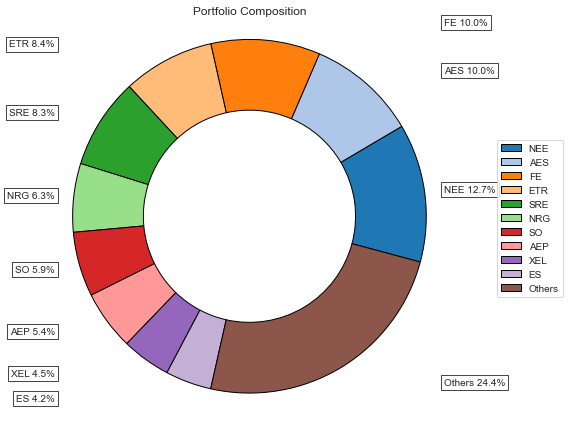

In [66]:
sector = 'Utilities'
sector_portfolio = rp.Portfolio(returns=prices_changes_train.loc[:, sectors_tickers.loc[sector]], nea=None)

sector_portfolio.assets_stats(method_mu='hist', method_cov='shrunk')

sector_portfolio.nea = len(sectors_tickers.loc[sector]) * (1 - valuable_gamma)
sector_portfolio.ainequality = np.eye(len(sectors_tickers.loc[sector]))
sector_portfolio.binequality = np.array([valuable_threshold] * len(sectors_tickers.loc[sector]))[:, np.newaxis]

w = sector_portfolio.optimization(model='Classic', rm='EVaR', obj='Sharpe', rf=0.00, l=0.2, hist=True)
rp.plot_pie(w, others=0.25)

In [67]:
w_s = sector_portfolio.efficient_frontier(rm='EVaR', points=30)

/home/hivaze/miniconda3/lib/python3.8/site-packages/riskfolio/RiskFunctions.py:349: RuntimeWarning:

overflow encountered in exp

/home/hivaze/miniconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



<AxesSubplot:title={'center':'Efficient Frontier Mean - Conditional Drawdown at Risk (CDaR)'}, xlabel='Expected Risk - Conditional Drawdown at Risk (CDaR)', ylabel='Expected Arithmetic Return'>

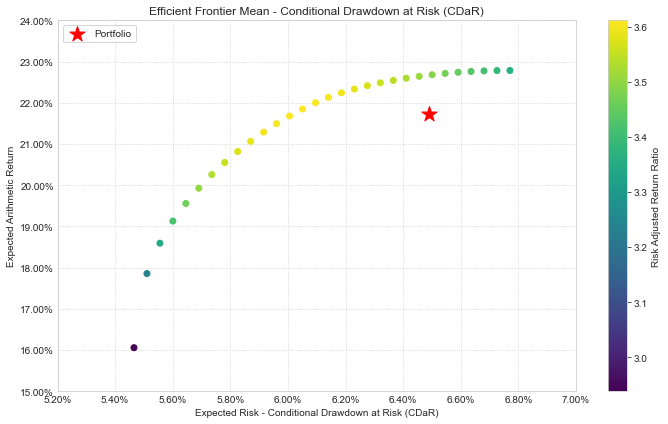

In [64]:
rp.plot_frontier(w_s, sector_portfolio.mu, sector_portfolio.cov, sector_portfolio.returns, rm="CDaR", w=w)

In [66]:
# fig = px.line(portfolios, template="plotly_dark", title='Baseline portfolios')
# fig.add_vline(x=prices_changes_train.iloc[-1].name)

## Pypfopt

In [103]:
mu = pypfopt.expected_returns.mean_historical_return(prices_changes, returns_data=True)
cov = pypfopt.risk_models.CovarianceShrinkage(prices_changes, returns_data=True).shrunk_covariance()

## Scipy: Global optimization